<a id="top"></a>

# Comparing Stellar Spectral Types with JWST Data: solutions

***

In [5]:
import matplotlib.pyplot as plt
import requests
import sys
import numpy as np
import warnings

from astroquery.simbad import Simbad

## Exercise 1
Compare an A star spectrum to a G star spectrum. How do the spectral features differ? Do they differ in expected ways?

We'll begin by collating the same observations as the previous notebook.

In [6]:
wav_range = '0,2'
min_flux = '1'
base_url = 'https://mast.stsci.edu/spectra/api/v0.1/search'
conditions = {'flux.gt': min_flux, 'wavelength': wav_range}
# submit the request
response = requests.post(base_url, json={'conditions': conditions,
                             'columns': ['targetName']})

# turn the response into a readable dictionary
response_data = response.json()

In [7]:
names = []
for d in response_data['results']:
    name = d['targetName']
    if name != '':
        names += [name]

In [8]:
customSimbad = Simbad()
customSimbad.add_votable_fields('sptype')

In [9]:
with warnings.catch_warnings():
    # disable warnings
    warnings.simplefilter("ignore")
    for name in np.unique(names):

        # query the object
        result = customSimbad.query_object(name)

        # ignore this object if no result is returned
        if not result:
            continue

        spectral_type = result['SP_TYPE'][0]

        # ignore this object if it has no spectral type
        if spectral_type == '':
            continue

        print(name, spectral_type)

2MASS J12560183-1257276 L8.0
2MASS J15395077-3404566 M0III
2MASS J16194609+5534178 G0-5
2MASS J17430448+6655015 A5V
2MASS J17540383-2810466 M4.5III
BD+04 3653 K5III
GCRV 21765 A0
GSPC P330-E G2V
TYC 3986-834-1 K0III
TYC 4433-1800-1 A3V
WD1657+343 DA.9


Let's download the G star from the main notebook first.

In [10]:
# access target files for G star

targetname = 'GSPC P330-E'

targetfiles = []

for d in response_data['results']:
    if d['targetName'] == targetname:
        targetfiles += [d['fileName']]

        
# retrieve our system's Python version for the request. 
version = ".".join(map(str, sys.version_info[:3]))
# create HTTP Header Variables
headers = {"Content-type": "application/x-www-form-urlencoded",
           "Accept": "text/plain",
           "User-agent":"python-requests/"+version}

# download first target file
targetfile = np.unique(targetfiles)[2]

request_url=f'https://mast.stsci.edu/spectra/api/v0.1/retrieve?filename={targetfile}'    

# perform the HTTP request
spectrum_response = requests.get(request_url, headers=headers)

spectrum_object = spectrum_response.json()

print(spectrum_object['message'])

# extract G star spectrum components

g_star_wav = np.array(spectrum_object['data']['wavelength'])

g_star_flux = np.array(spectrum_object['data']['flux'])
g_star_flux_err = np.array(spectrum_object['data']['fluxErr'])

# remove noisy G star spectral data
g_star_flux_masked = g_star_flux[g_star_flux_err/g_star_flux < 2]
g_star_flux_err_masked = g_star_flux_err[g_star_flux_err/g_star_flux < 2]
g_star_wav_masked = g_star_wav[g_star_flux_err/g_star_flux < 2]

# transform G star spectral data into log space
g_star_log_err = (1/np.log(10)) * g_star_flux_err_masked/g_star_flux_masked

Successfully found data for jw01538-o062_t002_nirspec_g235h-f170lp_x1d.fits


Now, let's examine the data for the star TYC 4433-1800-1.

In [64]:
targetname = '2MASS J17430448+6655015'
targetfiles = []

for d in response_data['results']:
    if d['targetName'] == targetname:
        targetfiles += [d['fileName']]


targetfile = np.unique(targetfiles)[0]

In [65]:
np.unique(targetfiles)

array(['jw01118-o003_t001_nirspec_g140m-f100lp_x1d.fits',
       'jw01118-o006_t001_nirspec_g140m-f100lp_x1d.fits'], dtype='<U47')

The last observation shares a filter with our G star observation, so we will retrieve the corresponding the spectrum.

In [66]:
targetfile = np.unique(targetfiles)[1]

request_url=f'https://mast.stsci.edu/spectra/api/v0.1/retrieve?filename={targetfile}'    

# perform the HTTP request
spectrum_response = requests.get(request_url, headers=headers)

spectrum_object = spectrum_response.json()

print(spectrum_object['message'])

# extract A star spectrum components

a_star_wav = np.array(spectrum_object['data']['wavelength'])

a_star_flux = np.array(spectrum_object['data']['flux'])
a_star_flux_err = np.array(spectrum_object['data']['fluxErr'])

# remove noisy A star spectral data
a_star_flux_masked = a_star_flux[a_star_flux_err/a_star_flux < 2]
a_star_flux_err_masked = a_star_flux_err[a_star_flux_err/a_star_flux < 2]
a_star_wav_masked = a_star_wav[a_star_flux_err/a_star_flux < 2]

# transform A star spectral data into log space
a_star_log_err = (1/np.log(10)) * abs(a_star_flux_err_masked)/abs(a_star_flux_masked)

Successfully found data for jw01118-o006_t001_nirspec_g140m-f100lp_x1d.fits


In [70]:
a_star_flux_masked

array([2.88495751e+07, 1.10597279e+08, 1.27609905e+08, ...,
       5.95634299e+07, 5.99142528e+07, 5.42723885e+07])

In [68]:
a_star_log_err.max()

33.40398632381332

/var/folders/zg/pp98nf5j52b0_pww3l0b71f40000gq/T/ipykernel_36960/3918573751.py:4: RuntimeWarning: invalid value encountered in log10
  markers, caps, bars = plt.errorbar(a_star_wav_masked, np.log10(a_star_flux_masked),
/var/folders/zg/pp98nf5j52b0_pww3l0b71f40000gq/T/ipykernel_36960/3918573751.py:17: RuntimeWarning: invalid value encountered in log10
  markers, caps, bars = plt.errorbar(g_star_wav_masked, np.log10(g_star_flux_masked),


Text(0, 0.5, 'Log10 Flux (Jy)')

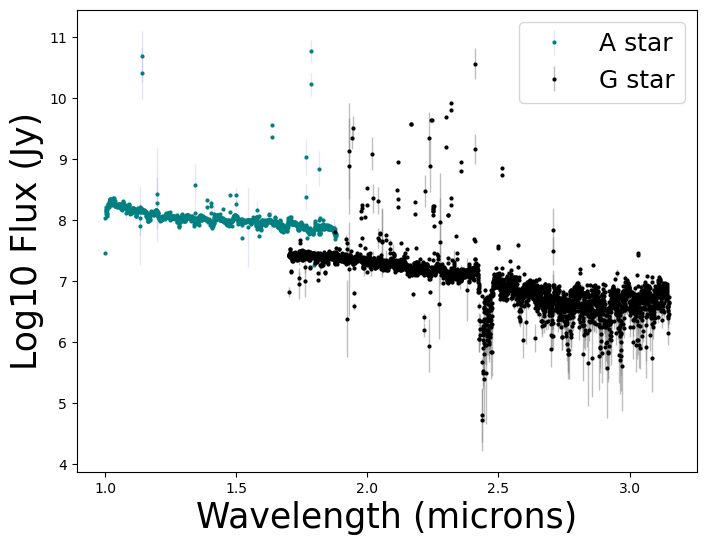

In [71]:
plt.figure(figsize=(8,6))


markers, caps, bars = plt.errorbar(a_star_wav_masked, np.log10(a_star_flux_masked), 
             yerr=a_star_log_err, 
             color='teal',
             fmt='.',
            ms=4,
            elinewidth=1,
            ecolor='blue', label='A star')

[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]



markers, caps, bars = plt.errorbar(g_star_wav_masked, np.log10(g_star_flux_masked), 
             yerr=g_star_log_err, 
             color='black',
             fmt='.',
            ms=4,
            elinewidth=1,
            ecolor='gray',
                                  label='G star')

[bar.set_alpha(0.5) for bar in bars]
[cap.set_alpha(0.5) for cap in caps]

# plt.scatter(wav, flux)

# plt.yscale('log')
# plt.ylim(5,7.5)
# plt.xlim(2.5, 2.7) 

plt.legend(fontsize=18)
plt.xlabel('Wavelength (microns)', fontsize=25)

plt.ylabel('Log10 Flux (Jy)', fontsize=25)

Both stars have a continuum slope over wavelength, and there are some features in the A star spectrum, some of which could be caused by hydrogen lines. These spectral features are much less strong than the G stars spectral feature, as expected — A stars tend to be fast rotators with few spectral features that are strongly rotationally broadened.

## Exercise 2
Find observations of Jupiter's emission spectrum over a wide wavelength range (e.g., 1 to 15 micron). Some spectral features are obvious by eye; what are they?

This time, we'll make a request based on target name instead of wavelength.

In [165]:
min_flux = '0'

In [166]:
conditions = {'targetName':'JUPITER', 'wavelength': '8,13','flux.gt': min_flux}

In [167]:
# submit the request
response = requests.post(base_url, json={'conditions': conditions,
                             'columns': ['targetName']})

# turn the response into a readable dictionary
response_data = response.json()

In [168]:
targetfiles = []
for d in response_data['results']:
    targetfiles += [d['fileName']]


In [169]:
np.unique(targetfiles)

array(['jw01022-o021_t001_miri_ch3-short_x1d.fits',
       'jw01022-o022_t001_miri_ch2-short_x1d.fits',
       'jw01022-o022_t001_miri_ch3-short_x1d.fits',
       'jw01022-o023_t001_miri_ch2-short_x1d.fits',
       'jw01022-o023_t001_miri_ch3-short_x1d.fits',
       'jw01022-o024_t001_miri_ch2-short_x1d.fits',
       'jw01022-o024_t001_miri_ch3-short_x1d.fits',
       'jw01022-o025_t001_miri_ch3-short_x1d.fits',
       'jw01022-o026_t001_miri_ch3-short_x1d.fits',
       'jw01246-c1001_t001_miri_ch2-shortmediumlong_x1d.fits',
       'jw01246-c1001_t001_miri_ch3-shortmediumlong_x1d.fits',
       'jw01246-o004_t002_miri_ch2-longshortmedium-_x1d.fits',
       'jw01246-o004_t002_miri_ch2-shortmediumlong_x1d.fits',
       'jw01246-o004_t002_miri_ch3-longshortmedium-_x1d.fits',
       'jw01246-o004_t002_miri_ch3-shortmediumlong_x1d.fits',
       'jw01246-o051_t004_miri_ch2-short_x1d.fits',
       'jw01246-o051_t004_miri_ch3-short_x1d.fits',
       'jw01246-o052_t001_miri_ch2-shortmediumlong_x

Let's pick out a few of these files, download them, and plot them.

Text(0, 0.5, 'Flux')

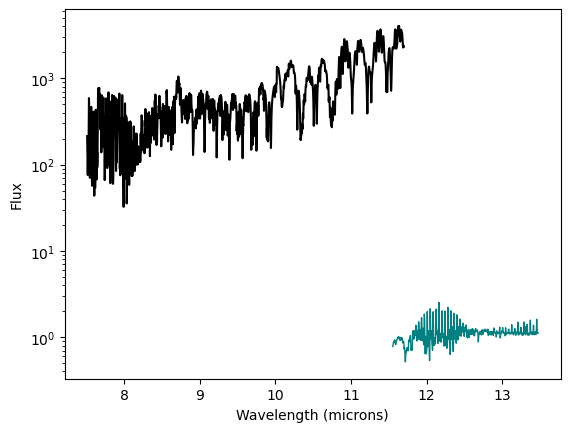

In [178]:
# download first target file
targetfile = np.unique(targetfiles)[2]
targetfile2 = np.unique(targetfiles)[9]

request_url=f'https://mast.stsci.edu/spectra/api/v0.1/retrieve?filename={targetfile}'    

# perform the HTTP request
spectrum_response = requests.get(request_url, headers=headers)

spectrum_object = spectrum_response.json()

# extract G star spectrum components

wav1 = np.array(spectrum_object['data']['wavelength'])

flux1 = np.array(spectrum_object['data']['flux'])

request_url=f'https://mast.stsci.edu/spectra/api/v0.1/retrieve?filename={targetfile2}'    

# perform the HTTP request
spectrum_response = requests.get(request_url, headers=headers)

spectrum_object = spectrum_response.json()

# extract G star spectrum components

wav2 = np.array(spectrum_object['data']['wavelength'])

flux2 = np.array(spectrum_object['data']['flux'])

plt.figure()
plt.plot(wav1, flux1, color='teal', lw=1)
plt.plot(wav2, flux2, color='black')
plt.yscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux')

By eye, the larger-scale features in this plot between 9 and 11 microns look like the $\rm NH_3$ bands expected from ground-based, mid-infrared spectra of Jupiter. Additionally, the shorter-scale features near 12 microns seem reminiscent of $\rm C_2H_6$ features expected based on previous observations. In particular, compare these spectra to Figure 2 of [Encrenaz et al. 1978](https://adsabs.harvard.edu/pdf/1978A%26A....70...29E).

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>
